# What is Classification?

## The Idea of Classification Problems

Classification Problems are supervised learning problems where the end goal is to take in unlabeled instances and give them a label.

The target, $y$, now is qualitative instead of quantitative. Meaning that it is for instance a binary choice, $0$ or $1$, or a series of categories $A$, $B$, $C$, $\dots$.

Let's bring back our classic data set, the iris data.

In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

In [2]:
# Load the data
iris = load_iris()
iris_df = pd.DataFrame(iris['data'],columns = ['sepal_length','sepal_width','petal_length','petal_width'])
iris_df['iris_class'] = iris['target']

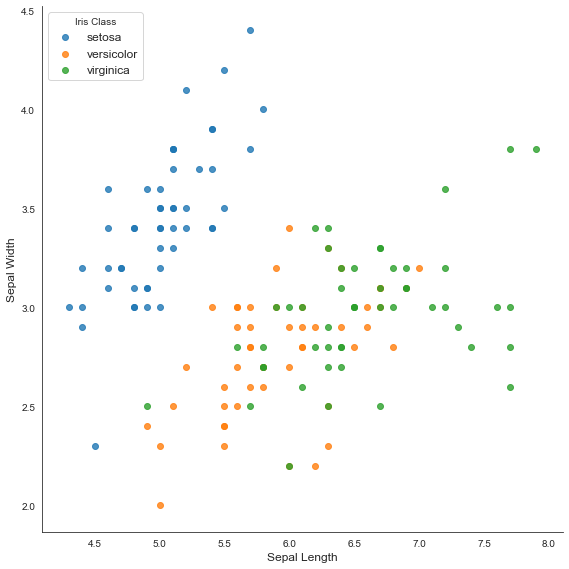

In [3]:
# This chunk of code is going to plot the data
sns.lmplot(data = iris_df, x = 'sepal_length', 
            y = 'sepal_width',hue = 'iris_class',fit_reg=False,
            height = 8,legend=False)

plt.legend(title='Iris Class', loc='upper left', 
           labels=['setosa', 'versicolor', 'virginica'], 
           fontsize = 12)
plt.xlabel("Sepal Length",fontsize = 12)
plt.ylabel("Sepal Width",fontsize = 12)

plt.show()

Since our iris data has three distinct classes, we can imagine a world in which we'd want to build a model that takes in `petal_width`,`petal_length`,`sepal_width`, and `sepal_length` then predicts what kind of iris we have.

People build entire business models around classification problems. For example, <a href="https://www.covermymeds.com/main/">CoverMyMeds</a> started by solving the problem "How can I predict whether or not my prescription will need a prior authorization form?". <a href="https://www.upstart.com/">Upstart</a> tries to predict whether or not someone will be a good candidate for their loans.

These problems are ubiquitous in our every day lives. Now lets start learning how we can use supervised learning techniques to solve them.

## Illustrating the Classification Process With a Simple Algorithm

We'll end this notebook by working through a classification problem with one of the simplest classification algorithms, $k$-nearest neighbors.

### KNN

$k$-nearest neighbors is quite straightforward. When you want to classify an unlabeled point, you find the $k$ closest other data points in the data space. Whichever class is most present among the $k$ neighbors is what the algorithm classifies the unlabeled point as. In the case of ties, the class is randomly assigned from the tied classes.

Let's look at a picture to see what we mean.

In [4]:
np.random.seed(440)
xs = np.random.randn(50,2)
os = np.random.randn(50,2)-np.array([3,0])

unlabeled = [0,0]

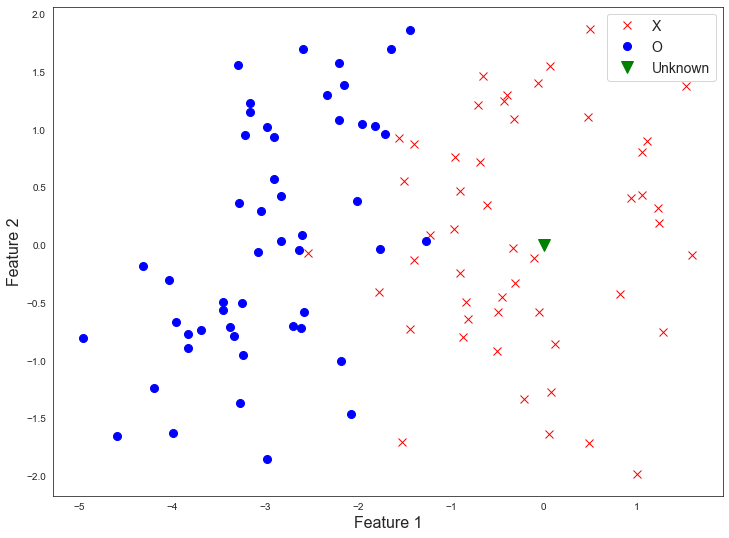

In [5]:
plt.figure(figsize = (12,9))

plt.plot(xs[:,0],xs[:,1],'rx',label = "X",markersize=8)
plt.plot(os[:,0],os[:,1],'bo',label = "O",markersize=8)
plt.plot(unlabeled[0],unlabeled[1],'gv',label = "Unknown",markersize=12)
plt.xlabel("Feature 1", fontsize = 16)
plt.ylabel("Feature 2", fontsize = 16)
plt.legend(fontsize = 14)
plt.show()

Looking at the plot above, how would would knn classify the unlabeled point for $k=1$, $k=2$, $k=10$?

### Building an iris classifier

We'll now demonstrate the flow of a classification problem, by using knn to build an iris classifier.

#### Preparing the Data

The iris dataset is the model dataset, meaning that it is already cleaned for us. In other applications in this section of the course we'll need to take an exploration and cleaning step, but for the iris data we only need to do our test/train split.

In [6]:
# import train_test_split
from sklearn.model_selection import train_test_split

In [7]:
# We can turn the data in numpy arrays
# like so
X = iris_df[['sepal_length','sepal_width','petal_length','petal_width']].to_numpy()
y = iris_df[['iris_class']].to_numpy()

 
# make the test data 25% of the total data
# Set a random seed
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.25, random_state=440)

#### Fitting the Model

Now we can fit the model to our train data, let's use $k=3$.

In [8]:
# import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

In [9]:
# Make the model
knn = KNeighborsClassifier(n_neighbors = 3)

In [10]:
# Fit the model
knn.fit(X_train,y_train.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

### Performance Measures - Accuracy 

One way to measure how well our model did is to calculate its <i>accuracy</i>. Accuracy is the number of correct predictions divided by the number of total predictions we made. Let's see how well our model does, on our training set.

In [11]:
# Make a prediction on our train set
y_predict = knn.predict(X_train)

In [12]:
# calculate the accuracy here
print("Our model has a ",
      np.round(sum(y_predict == y_train.ravel())/len(y_train)*100,2),
      "% accuracy on the training set")

Our model has a  95.54 % accuracy on the training set


That's not too bad!

What could we do to our model to change our accuracy? We could change the number of neighbors!

Also, is there anything else we could do to get a better idea of the generalization error? Yes, CV!

### Cross Validation for Model Assessment

Just as we did for some of our regression models we can assess multiple models at once and compare the average accuracies of them all to choose the best model.

### Practice

Implement CV with $5$ splits. Set a random state so you could recreate your split. Going from $1$ to $25$ neighbors find the model that has the best CV accuracy.

In [13]:
# import kfold
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [14]:
max_neighbors = 25

# make the kfold object
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state = 440)

# make an empty array that will hold all of our accuracy measures
accs = np.empty([max_neighbors,n_splits])

# We'll go from 1 to 10 neighbors
for i in range(1,max_neighbors+1):
    # make knn
    knn = KNeighborsClassifier(n_neighbors = i)
    # We'll get the accuracy for each split
    j = 1
    for train_index, test_index in kfold.split(X_train,y_train):
        X_train_folds = X_train[train_index]
        y_train_folds = y_train[train_index]
        X_test_fold = X_train[test_index]
        y_test_fold = y_train[test_index]
        
        clone_knn = clone(knn)
        clone_knn.fit(X_train_folds,y_train_folds.ravel())
        y_pred = clone_knn.predict(X_test_fold)
        accs[i-1,j-1] = np.round(sum(y_pred == y_test_fold.ravel())/len(y_pred),4)
        j = j+1
        

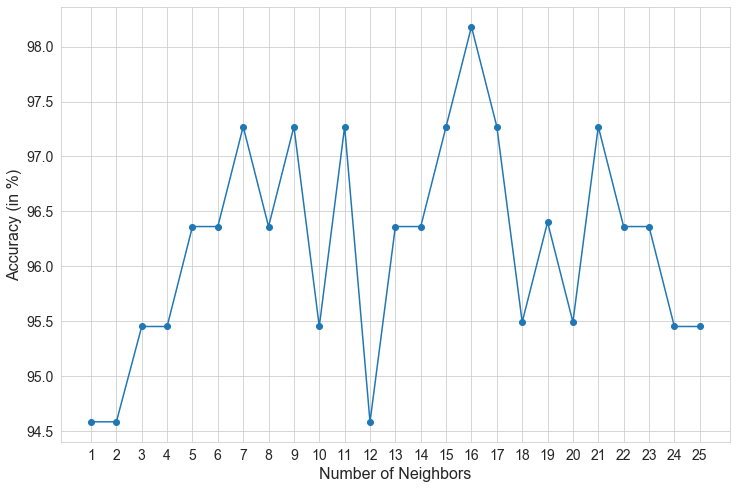

In [15]:
# Plot how the accuracy changes
sns.set_style("whitegrid")

plt.figure(figsize = (12,8))
plt.plot(range(1,max_neighbors+1),np.mean(accs*100,axis = 1),'-o')

plt.xticks(range(1,max_neighbors+1),fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Number of Neighbors",fontsize = 16)
plt.ylabel("Accuracy (in %)",fontsize = 16)
plt.show()

From the above plot it looks like the "best" model here is going to be which one? $16$ neighbors.

Let's go ahead and calculate accuracy on our test set using this best model. Do that below.

In [ ]:
# Write your code here
knn = KNeighborsClassifier(16)

knn.fit(X_train,y_train.ravel())


pred = knn.predict(X_test)

In [ ]:
# Write a snippet of code that prints out the test accuracy here


np.round(sum(pred == y_test.ravel())/len(pred),4)





### Summary

#### knn

KNN is a nice little algorithm, it is easy to understand and implement. Unlike other models we've seen and will see, there is no training period. Unfortunately, this means the algorithm does not scale well with large data sets. In addition, if your data has different distance scales, you'll need to do some cleaning before using knn. You can explore it more in the HW.

#### General Classification Lessons Learned

While we focused on accuracy in this notebook, it is not always the best performance measure. As we continue in the classification section we'll learn more about other important performance measures. However, the problem we presented above does show a common pattern for classification problems. You choose a desired measure, then use cross validation to find the model that optimizes that measure.